# Aggregate variant counts for all samples
Separate `Snakemake` rules count the observations of each variant in each sample from the Illumina barcode sequencing.
This Python Jupyter notebook aggregates all of this counts, and then adds them to a codon variant table.

## Set up analysis
### Import Python modules.
Use [plotnine](https://plotnine.readthedocs.io/en/stable/) for ggplot2-like plotting.

The analysis relies heavily on the Bloom lab's [dms_variants](https://jbloomlab.github.io/dms_variants) package:

In [1]:
import glob
import itertools
import math
import os
import warnings

import Bio.SeqIO

import dms_variants.codonvarianttable
from dms_variants.constants import CBPALETTE
import dms_variants.utils
import dms_variants.plotnine_themes

from IPython.display import display, HTML

import pandas as pd

from plotnine import *

import yaml

Set [plotnine](https://plotnine.readthedocs.io/en/stable/) theme to the gray-grid one defined in `dms_variants`:

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [3]:
print(f"Using dms_variants version {dms_variants.__version__}")

Using dms_variants version 0.8.10


Ignore warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Read the configuration file:

In [5]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory if needed:

In [6]:
os.makedirs(config['counts_dir'], exist_ok=True)

## Initialize codon variant table
Initialize the [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) using the wildtype gene sequence and the CSV file with the table of variants:

In [7]:
wt_seqrecord = Bio.SeqIO.read(config['wildtype_sequence'], 'fasta')
geneseq = str(wt_seqrecord.seq)
primary_target = wt_seqrecord.name
print(f"Read sequence of {len(geneseq)} nt for {primary_target} from {config['wildtype_sequence']}")
      
print(f"Initializing CodonVariantTable from gene sequence and {config['codon_variant_table']}")
      
variants = dms_variants.codonvarianttable.CodonVariantTable(
                geneseq=geneseq,
                barcode_variant_file=config['codon_variant_table'],
                substitutions_are_codon=True,
                substitutions_col='codon_substitutions',
                primary_target=primary_target)

Read sequence of 603 nt for B1351 from data/wildtype_sequence.fasta
Initializing CodonVariantTable from gene sequence and results/variants/codon_variant_table.csv


## Read barcode counts / fates
Read data frame with list of all samples (barcode runs):

In [8]:
print(f"Reading list of barcode runs from {config['barcode_runs']}")

barcode_runs = (pd.read_csv(config['barcode_runs'])
                .assign(sample_lib=lambda x: x['sample'] + '_' + x['library'],
                        counts_file=lambda x: config['counts_dir'] + '/' + x['sample_lib'] + '_counts.csv',
                        fates_file=lambda x: config['counts_dir'] + '/' + x['sample_lib'] + '_fates.csv',
                        )
                .drop(columns='R1')  # don't need this column, and very large
                )

assert all(map(os.path.isfile, barcode_runs['counts_file'])), 'missing some counts files'
assert all(map(os.path.isfile, barcode_runs['fates_file'])), 'missing some fates files'

display(HTML(barcode_runs.to_html(index=False)))

Reading list of barcode runs from data/barcode_runs.csv


date,experiment,library,antibody,concentration,sort_bin,selection,sample,experiment_type,number_cells,frac_escape,sample_lib,counts_file,fates_file
220118,beta_19-26,lib1,none,0,ref,reference,beta_19-26-none-0-ref,ab_selection,NaN,NaN,beta_19-26-none-0-ref_lib1,results/counts/beta_19-26-none-0-ref_lib1_counts.csv,results/counts/beta_19-26-none-0-ref_lib1_fates.csv
220118,beta_19-26,lib2,none,0,ref,reference,beta_19-26-none-0-ref,ab_selection,NaN,NaN,beta_19-26-none-0-ref_lib2,results/counts/beta_19-26-none-0-ref_lib2_counts.csv,results/counts/beta_19-26-none-0-ref_lib2_fates.csv
220118,beta_19,lib1,mosaic_6848,3125,abneg,escape,beta_19-mosaic_6848-3125-abneg,ab_selection,875492.0,0.096,beta_19-mosaic_6848-3125-abneg_lib1,results/counts/beta_19-mosaic_6848-3125-abneg_lib1_counts.csv,results/counts/beta_19-mosaic_6848-3125-abneg_lib1_fates.csv
220118,beta_19,lib2,mosaic_6848,3125,abneg,escape,beta_19-mosaic_6848-3125-abneg,ab_selection,1002826.0,0.136,beta_19-mosaic_6848-3125-abneg_lib2,results/counts/beta_19-mosaic_6848-3125-abneg_lib2_counts.csv,results/counts/beta_19-mosaic_6848-3125-abneg_lib2_fates.csv
220118,beta_20,lib1,mosaic_6849,3125,abneg,escape,beta_20-mosaic_6849-3125-abneg,ab_selection,957229.0,0.105,beta_20-mosaic_6849-3125-abneg_lib1,results/counts/beta_20-mosaic_6849-3125-abneg_lib1_counts.csv,results/counts/beta_20-mosaic_6849-3125-abneg_lib1_fates.csv
220118,beta_20,lib2,mosaic_6849,3125,abneg,escape,beta_20-mosaic_6849-3125-abneg,ab_selection,1100621.0,0.132,beta_20-mosaic_6849-3125-abneg_lib2,results/counts/beta_20-mosaic_6849-3125-abneg_lib2_counts.csv,results/counts/beta_20-mosaic_6849-3125-abneg_lib2_fates.csv
220118,beta_21,lib1,mosaic_6850,3125,abneg,escape,beta_21-mosaic_6850-3125-abneg,ab_selection,862307.0,0.089,beta_21-mosaic_6850-3125-abneg_lib1,results/counts/beta_21-mosaic_6850-3125-abneg_lib1_counts.csv,results/counts/beta_21-mosaic_6850-3125-abneg_lib1_fates.csv
220118,beta_21,lib2,mosaic_6850,3125,abneg,escape,beta_21-mosaic_6850-3125-abneg,ab_selection,938801.0,0.105,beta_21-mosaic_6850-3125-abneg_lib2,results/counts/beta_21-mosaic_6850-3125-abneg_lib2_counts.csv,results/counts/beta_21-mosaic_6850-3125-abneg_lib2_fates.csv
220118,beta_22,lib1,mosaic_6851,3125,abneg,escape,beta_22-mosaic_6851-3125-abneg,ab_selection,751160.0,0.080,beta_22-mosaic_6851-3125-abneg_lib1,results/counts/beta_22-mosaic_6851-3125-abneg_lib1_counts.csv,results/counts/beta_22-mosaic_6851-3125-abneg_lib1_fates.csv
220118,beta_22,lib2,mosaic_6851,3125,abneg,escape,beta_22-mosaic_6851-3125-abneg,ab_selection,952949.0,0.103,beta_22-mosaic_6851-3125-abneg_lib2,results/counts/beta_22-mosaic_6851-3125-abneg_lib2_counts.csv,results/counts/beta_22-mosaic_6851-3125-abneg_lib2_fates.csv


Confirm sample / library combinations unique:

In [9]:
assert len(barcode_runs) == len(barcode_runs.groupby(['sample', 'library']))

Make sure the the libraries for which we have barcode runs are all in our variant table:

In [10]:
unknown_libs = set(barcode_runs['library']) - set(variants.libraries)
if unknown_libs:
    raise ValueError(f"Libraries with barcode runs not in variant table: {unknown_libs}")

Now concatenate the barcode counts and fates for each sample:

In [11]:
counts = pd.concat([pd.read_csv(f) for f in barcode_runs['counts_file']],
                   sort=False,
                   ignore_index=True)

print('First few lines of counts data frame:')
display(HTML(counts.head().to_html(index=False)))

fates = pd.concat([pd.read_csv(f) for f in barcode_runs['fates_file']],
                  sort=False,
                  ignore_index=True)

print('First few lines of fates data frame:')
display(HTML(fates.head().to_html(index=False)))

First few lines of counts data frame:


barcode,count,library,sample
AAAGATACTACATGGT,17357,lib1,beta_19-26-none-0-ref
GCATATGCTAGTAATG,16395,lib1,beta_19-26-none-0-ref
TAGCCAGCTAACCTAA,14685,lib1,beta_19-26-none-0-ref
GCACATCTAGTAAGAT,14104,lib1,beta_19-26-none-0-ref
ACAGATGATTACAAAA,13805,lib1,beta_19-26-none-0-ref


First few lines of fates data frame:


fate,count,library,sample
valid barcode,50742238,lib1,beta_19-26-none-0-ref
invalid barcode,9133928,lib1,beta_19-26-none-0-ref
low quality barcode,3405417,lib1,beta_19-26-none-0-ref
failed chastity filter,1201254,lib1,beta_19-26-none-0-ref
unparseable barcode,1121594,lib1,beta_19-26-none-0-ref


## Examine fates of parsed barcodes
First, we'll analyze the "fates" of the parsed barcodes.
These fates represent what happened to each Illumina read we parsed:
 - Did the barcode read fail the Illumina chastity filter?
 - Was the barcode *unparseable* (i.e., the read didn't appear to be a valid barcode based on flanking regions)?
 - Was the barcode sequence too *low quality* based on the Illumina quality scores?
 - Was the barcode parseable but *invalid* (i.e., not in our list of variant-associated barcodes in the codon variant table)?
 - Was the barcode *valid*, and so will be added to variant counts.
 
First, we just write a CSV file with all the barcode fates:

In [12]:
fatesfile = os.path.join(config['counts_dir'], 'barcode_fates.csv')
print(f"Writing barcode fates to {fatesfile}")
fates.to_csv(fatesfile, index=False)

Writing barcode fates to results/counts/barcode_fates.csv


Next, we tabulate the barcode fates in wide format:

In [13]:
display(HTML(fates
             .pivot_table(columns='fate',
                          values='count',
                          index=['sample', 'library'])
             .applymap('{:.1e}'.format)  # scientific notation
             .to_html()
             ))

Now we plot the barcode-read fates for each library / sample, showing the bars for valid barcodes in orange and the others in gray.
We see that the largest fraction of barcode reads correspond to valid barcodes, and most of the others are invalid barcodes (probably because the map to variants that aren't present in our variant table since we didn't associate all variants with barcodes). The exception to this is lib2 Titeseq_03_bin3; the PCR for this sample in the original sequencing run failed, so we followed it up with a single MiSeq lane. We did not filter out the PhiX reads from this data before parsing, so these PhiX reads will deflate the fraction of valid barcode reads as expected, but does not indicate any problems.

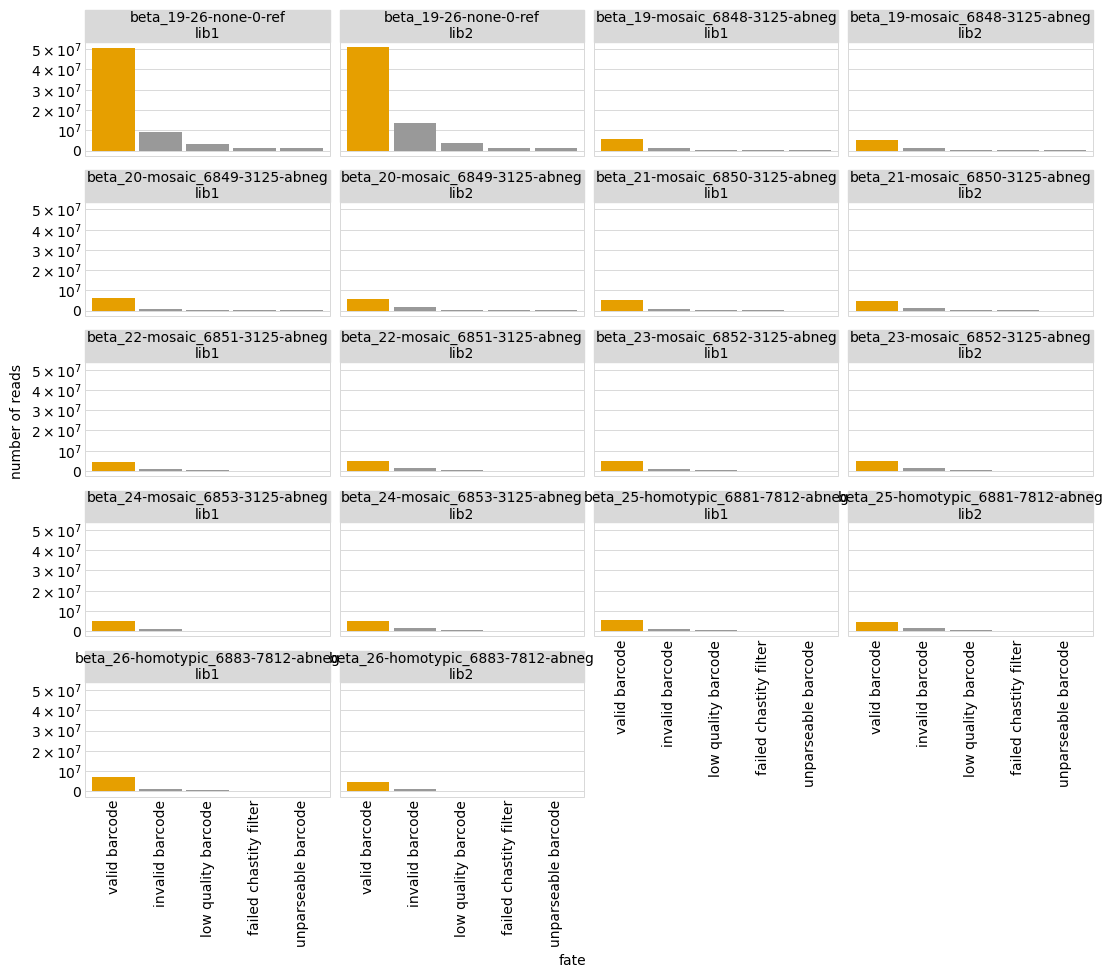

In [14]:
ncol = 4
nfacets = len(fates.groupby(['sample', 'library']))

barcode_fate_plot = (
    ggplot(
        fates
        .assign(sample=lambda x: pd.Categorical(x['sample'],
                                                x['sample'].unique(),
                                                ordered=True),
                fate=lambda x: pd.Categorical(x['fate'],
                                              x['fate'].unique(),
                                              ordered=True),
                is_valid=lambda x: x['fate'] == 'valid barcode'
                ), 
        aes('fate', 'count', fill='is_valid')) +
    geom_bar(stat='identity') +
    facet_wrap('~ sample + library', ncol=ncol) +
    scale_fill_manual(CBPALETTE, guide=False) +
    theme(figure_size=(3.25 * ncol, 2 * math.ceil(nfacets / ncol)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank()
          ) +
    scale_y_continuous(labels=dms_variants.utils.latex_sci_not,
                       name='number of reads')
    )

_ = barcode_fate_plot.draw()

## Add barcode counts to variant table
Now we use the [CodonVariantTable.add_sample_counts_df](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.add_sample_counts_df) method to add the barcode counts to the variant table:

In [15]:
variants.add_sample_counts_df(counts)

The variant table now has a `variant_count_df` attribute that gives a data frame of all the variant counts.
Here are the first few lines:

In [16]:
display(HTML(variants.variant_count_df.head().to_html(index=False)))

target,library,sample,barcode,count,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
B1351,lib1,beta_19-26-none-0-ref,AAAGATACTACATGGT,17357,36,CCT7AGA GCG190TCT,P7R A190S,2,2
B1351,lib1,beta_19-26-none-0-ref,GCATATGCTAGTAATG,16395,30,ATA104ATG,I104M,1,1
B1351,lib1,beta_19-26-none-0-ref,TAGCCAGCTAACCTAA,14685,33,CTT5TGT,L5C,1,1
B1351,lib1,beta_19-26-none-0-ref,GCACATCTAGTAAGAT,14104,39,TTT62TCT ACC148ACT,F62S,2,1
B1351,lib1,beta_19-26-none-0-ref,ACAGATGATTACAAAA,13805,28,TCT53GCT,S53A,1,1


Write the variant counts data frame to a CSV file.
It can then be used to re-initialize a [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) via its [from_variant_count_df](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.from_variant_count_df) method:

In [17]:
print(f"Writing variant counts to {config['variant_counts']}")
variants.variant_count_df.to_csv(config['variant_counts'], index=False, compression='gzip')

Writing variant counts to results/counts/variant_counts.csv.gz


The [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) has lots of nice functions that can be used to analyze the counts it contains.
However, we do that in the next notebook so we don't have to re-run this entire (rather computationally intensive) notebook every time we want to analyze a new aspect of the counts.